## Import and set parameters

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from numpy import vectorize, sqrt, inf
from scipy.constants import pi, k, mu_0
from lmfit import Parameters
import glob
from matplotlib.ticker import AutoMinorLocator
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit

# some global plotting parameters
plt.rcParams['font.size'] = 22.5
plt.rcParams['axes.linewidth'] = 2.5

# set font to bold and Arial
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

# set colors
colors = ['#0033CC','#009966','#A3142E','#7D2E8F','#a6d854']

## Import data - .csv of magnetization curves containing temp, field, moment

In [2]:
# sample name
sample = 'A_KMK273'

# change directory to path containing file
os.chdir('/Users/Kyle/Documents/UCSD/Research/Paper_2/Fig_3_Magnetism/Fig_3a')

# import csv, including rest of the file name, drop index column
MvsH = pd.read_csv(sample + '_300K_MvsH.csv', index_col=0)

# identify unique temperatures, if any exist
unique_temps = MvsH.Temp.unique()

# create a dictionary to store the dataframe(s) for each temperature
MvsH_Dict = {elem : pd.DataFrame() for elem in unique_temps}

# fill the dictionary: type "MvsH_Dict[temp]" to return the values for only that temp
for key in MvsH_Dict.keys():
    MvsH_Dict[key] = MvsH[:][MvsH.Temp == key]
    
# select temperature manually
temp = 300

# reset index and remove extraneous 'index' column
MvsH_Dict[temp].reset_index(drop=True, inplace=True)

## Select data: forward scan of MvsH loop

In [3]:
# selects first point of index
loop_start = MvsH_Dict[temp].index[0]

# selects last point of index
loop_end = MvsH_Dict[temp].index[-1] 

# select start and end of the forward scan from -7T to 7T
forward_start = int(loop_start)
forward_end = int(loop_end/2+1)

# select start and end of the reverse scan from 7T to -7T
reverse_start = int(loop_end/2)
reverse_end = int(loop_end)

# select data for fitting
x_data = np.array(MvsH_Dict[temp].Field_True[forward_start:forward_end])
y_data = np.array(MvsH_Dict[temp].Moment_emu_g[forward_start:forward_end])

## Manipulate data for fitting
Interpolates the data to give more points that are equally spaced, preventing emphasis of the fit near 0 field

[]

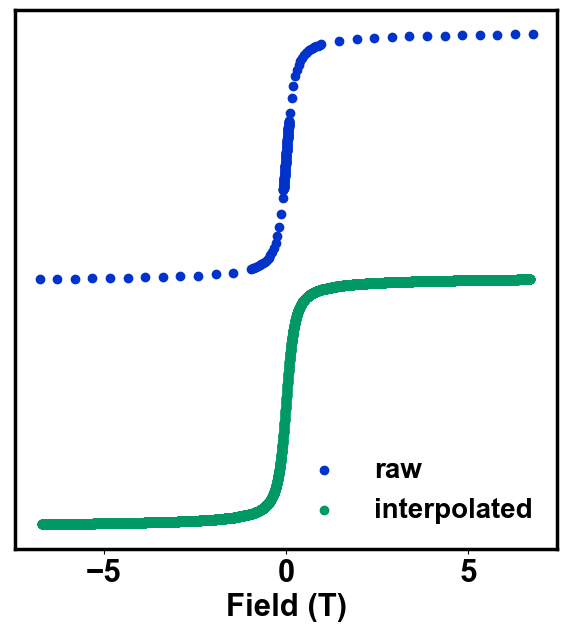

In [4]:
# can choose 'linear' or 'cubic' interpolation
y_func_interp = interp1d(x_data, y_data, 'linear') 

# generate equally spaced points (10,000 in total) for forward scan, but must be inside range of fields
x_data_interp = np.linspace(-6.7, 6.7, 10000)

# plug the equally spaced points back into the interpolated function
y_data_interp = y_func_interp(x_data_interp)

# quick plot to compare
plt.figure(figsize = (7 , 7))
plt.scatter(x_data, y_data, color = colors[0], label = 'raw')
plt.scatter(x_data_interp, y_data_interp-2*max(y_data), color = colors[1], label = 'interpolated')
plt.xlabel('Field (T)')

plt.legend(loc ='lower right',fontsize = 20, frameon = False)
ax = plt.gca()
ax.set_yticklabels([])
ax.set_yticks([])

## Specify fit parameters

In [5]:
# make empty dictionary, then fill it with parameters
params = Parameters()

# fit parameters
params.add('Xp', value = 0   , vary = True , min = -2 , max = 2) # Para/diamagnetic suscpetibility (emu/g * T)
params.add('gamma' , value = 0.01 , vary = True , min = 0.00001 , max = 1)  # gamma (unitless)
params.add('Hc' , value = 0 , vary = True , min = -0.01 , max = 0.01)  # Coercivity (T)
params.add('Ms' , value = 75 , vary = True , min = 1 , max = 100)  # Saturation magnetization (emu/g)

In [6]:
# fit equation
def MagArctan(x_data_interp, params):
    v = params.valuesdict()
    return v['Xp']*x_data_interp + ((2*v['Ms'])/np.pi *np.arctan((x_data_interp - v['Hc'])/v['gamma']))

In [7]:
# define the model
def fit_function(params, x_data_interp, y_data_interp):
    model = MagArctan(x_data_interp, params)
    resid = y_data_interp - model
    return resid

# run the fit
minner = Minimizer(fit_function, params, fcn_args=(x_data_interp, y_data_interp))
result = minner.minimize()

# print out result
result

In [8]:
# change output directory
os.chdir('/Users/Kyle/Documents/UCSD/Research/Paper_2/Fig_3_Magnetism/Fig_3d')

# Compare data to fit

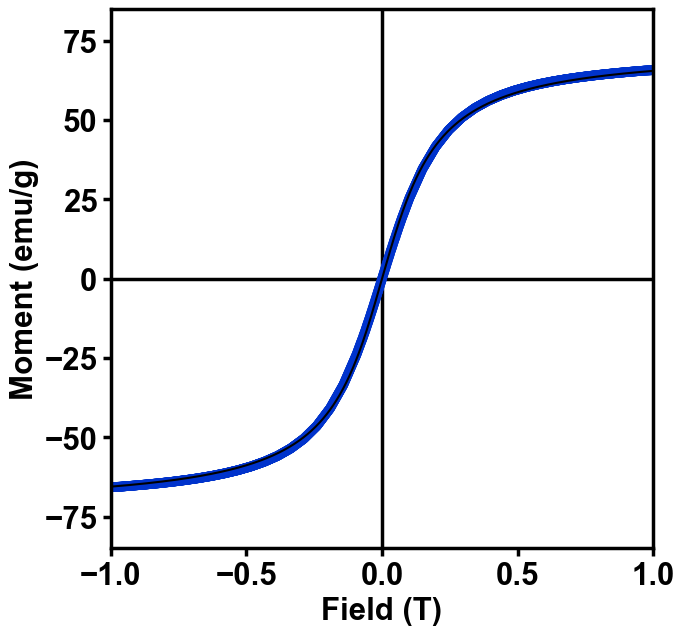

In [9]:
# plug final fit parameters into the function
y_fitted = MagArctan(x_data_interp, result.params)

# plot data (blue) with fit (black)
plt.figure(figsize = (7 , 7))
plt.scatter(x_data_interp, y_data_interp, facecolors='none', edgecolors=colors[0])
plt.plot(x_data_interp, y_fitted, 'k')

# horizontal and vertical lines
plt.axhline(y=0, xmin=0, xmax=1, linewidth=2.5, color = 'k', zorder=0)
plt.axvline(x=0, ymin=0, ymax=1, linewidth=2.5, color='k', zorder=0)

# plot parameters
plt.ylim([-85, 85])
plt.xlim([-1, 1])
plt.xlabel('Field (T)')
plt.ylabel('Moment (emu/g)')
ax = plt.gca()
plt.tick_params(which = 'major', width=2.5, length=6)

# export as .png
MvsH_text = sample + '_Arctan' + '.png'
plt.savefig(MvsH_text, dpi = 1000, bbox_inches = 'tight')

# Visualize derivative

Max susceptibility is: 300.02776435683245(emu/g * T)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


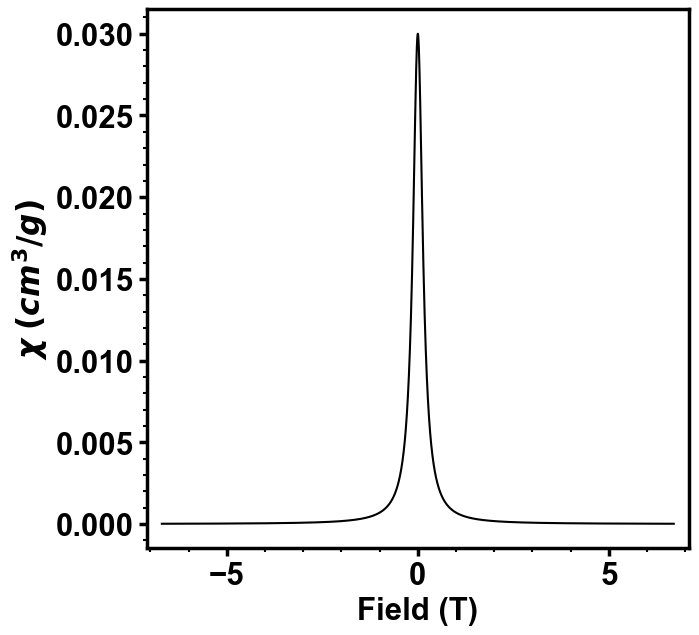

In [10]:
plt.figure(figsize = (7 , 7))

# Take derivative of fit and print the max
dydx = np.gradient(y_fitted)/np.gradient(x_data_interp)
print('Max susceptibility is: ' + str(np.max(dydx)) + '(emu/g * T)')

# plot data with fit
plt.plot(x_data_interp, dydx/10000, 'k')

# plot parameters
plt.xlim([-7.1, 7.1])
plt.xlabel('Field (T)')
plt.ylabel(r'$\chi$ $(cm^3/g)$')
plt.minorticks_on()
plt.tick_params(which = 'minor', width=1.5, length=3)
plt.tick_params(which = 'major', width=2.5, length=6)

# export as .png
Derivative_text = sample + '_Arctan_derivative' + '.png'
plt.savefig(Derivative_text, dpi = 1000, bbox_inches = 'tight')

In [11]:
# Save derivative data
dydx_text = sample + '_dydx.csv'
np.savetxt(dydx_text,np.transpose([x_data_interp, dydx]),header='Field_T,dydx', delimiter=',', comments='')